In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import circ_regression_tools as CR
from DecodeNoiseCorrelation import noiseModeling as DNC
import seaborn as sns
import scipy.stats

In [3]:
import matplotlib 
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [4]:
# fname = 'weights_deconvolve_2Gamma.pickle'
fname = 'weights_deconvolve_2Gamma_v3.pickle'
floc = '../DataDeconvolution/'
# floc = '/mnt/neurocube/local/serenceslab/tsheehan/py_code/fMRI_Processing/'
block_dat = pd.read_pickle(floc+fname)
bad_sess = ['201910011846','201907231305'] # sessions with technical issues to be removed

In [5]:
subjs = [54,60,61,62,63,64]
subjs = ['UCSD0' + str(i) for i in subjs]
dat_loc = '../DataDeconvolution//'
DAT = pd.Series()
for subj in subjs:
    print(subj)
    this_file = dat_loc+subj + '_weights_singleVox_decov.npy'
    this_dat = np.load(this_file,allow_pickle=True)
    DAT[subj]=this_dat.item()

UCSD054
UCSD060
UCSD061
UCSD062
UCSD063
UCSD064


<ipython-input-5-012fe3f53823>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  DAT = pd.Series()


In [6]:
dat=DAT
subjs = dat.keys()
rois = np.array(['V1', 'V2', 'V3', 'hV4', 'V3AB', 'IPS0'])
n_subj = len(subjs)
n_roi = len(rois)
pi=np.pi

In [26]:
def wrap(x):
    x[np.abs(x)>90]-=180*np.sign(x[np.abs(x)>90])
    return x

def ori_plot(l=0,y=0):
    if l:
        plt.plot([-90,90],[0,0],'c-')
    plt.xlim(-90,90)
    plt.xticks([-90,-45,0,45,90])
    if y:
        plt.ylim(-90,90)
        plt.yticks([-90,-45,0,45,90])
        
        
def sem_plot(x,y,axs=0,do_line=0,within_E=0,do_sd=False,do_errorbars=False,**args):
    # x is assumed to be examples x len(y)
    n_ex,n_points =  y.shape
    n_ex = np.sum(~np.isnan(y),0)
    assert n_points==len(x), 'x not correct shape'
    m_y = np.nanmean(y,0)
    if within_E:
        y_use = (y.T-np.mean(y,1)).T
        s_y = np.nanstd(y_use,0)/np.sqrt(n_ex)
    else:
        s_y = np.nanstd(y,0)/np.sqrt(n_ex)
    if do_sd:
        s_y = np.std(y,0)
    if do_errorbars:
        plt.errorbar(x,m_y,s_y,**args)
        return
    if axs==0:
        plt.fill_between(x,m_y-s_y,m_y+s_y,**args)
        if do_line:
            plt.plot(x,m_y,**args)
    else:
        axs.fill_between(x,m_y-s_y,m_y+s_y,**args)
        axs.plot(x,m_y,**args)
        
k = np.sqrt(2)/np.exp(-0.5)
def DoG(p,x_min_deg):
    a,w = p
    y = x_min_deg*a*w*k*np.exp(-(w*x_min_deg)**2)
    return y

def min_fun_dog_neural(p,vals):
    x_min,eRecon = vals
    bias = DoG(p,x_min)
    return np.sqrt(np.sum(wrap(eRecon - DoG(p,x_min) )**2))

def std_e(x): return np.std(x)/np.sqrt(len(x))

def get_nb(var,nb):
    """ returns d stim at given number back"""
    ang = np.max(var)>180
    if nb>0:
        this_d =np.concatenate((np.zeros(nb),var[:-nb]-var[nb:]))
        bad_d = np.isnan(this_d)
        bad_d[:nb] = 1
    elif nb<0:
        this_d = np.concatenate((var[-nb:]-var[:nb],np.zeros(-nb)))
        bad_d = np.isnan(this_d)
        bad_d[nb:] = 1
    else:
        this_d = var
        bad_d = np.zeros(len(var))
    if ang:
        this_d = wrap_ang(this_d)
    else:
        this_d = wrap(this_d)
    return (this_d,bad_d)


In [28]:
def circ_mean(x):
    # along first dimension if multi-dim
    rng_90 = np.max(np.abs(x))<=90
    if rng_90:
        return np.angle(np.sum(np.exp(1j*x/90*pi),0))*90/pi
#         return np.angle(np.sum(np.exp(1j*x/90*pi)))*90/pi
    else:
        return np.angle(np.sum(np.exp(1j*x/90*pi/2),0))*90/pi*2
#         return np.angle(np.sum(np.exp(1j*x/90*pi/2)))*90/pi*2
    
def circ_std(x):
    rng_90 = np.max(np.abs(x))<=90
    if rng_90:
        R = np.abs(np.mean(np.exp(1j*x/90*pi),0))
    else:
        R = np.abs(np.mean(np.exp(1j*x/90*pi/2),0))
    return np.sqrt(-2*np.log(R))


def do_bining(bns,overlap,grouping_var,var,var2=[-999],do_gauss=False,want_var=0,flip=0,prior_gauss=[5,0]):
    global obs, d_use_rad
    n_bns=len(bns)
    grouper = np.zeros(len(bns))
    if var2[0]!=-999:
        do_SDT=1
        out = np.zeros((2,len(bns)))
        if flip:

            grouping_var = np.concatenate((grouping_var,-grouping_var))
            var = np.concatenate((var,(var==0)*1))
            var2 = np.concatenate((var2,-var2))
    else:
        do_SDT=0
        out = np.zeros(len(bns))
        if flip:
            grouping_var = np.concatenate((grouping_var,-grouping_var))
            if flip==2:
                var = np.concatenate((var,var))
            elif flip==1:
                var = np.concatenate((var,-var))
    for i in range(n_bns):
        if i<overlap:
            these_ind = (grouping_var<=bns[i+overlap]) | (grouping_var>=bns[i-overlap])
        elif i>(n_bns-overlap-1):
            these_ind = (grouping_var>=bns[i-overlap]) | (grouping_var<=bns[i+overlap-n_bns])
        else:
            these_ind = (grouping_var>=bns[i-overlap])&(grouping_var<=bns[i+overlap]) # need to figure out 
        if do_SDT:
            obs = var[these_ind].copy()
            d_use_rad = var2[these_ind].copy()
            if do_gauss:
#                 d_use_rad*=90/pi
                dat_in =(var[these_ind], var2[these_ind]*90/pi)
                fit = scipy.optimize.minimize(min_fun_gauss,prior_gauss,args=(dat_in,),bounds=((0.01,45),(-45,45)) )
                out[:,i] = [fit.x[0],-fit.x[1]]
            else:
                fit = scipy.optimize.minimize(min_fun_SDT,[10,0],bounds=((0.001,500),(-pi/2,pi/2)))
                out[:,i] = [fit.x[0],-fit.x[1]/pi*90]
                
        else:
            if want_var==1:
                out[i] = np.var(var[these_ind])
            elif want_var==3:
                out[i] = np.angle(np.mean(np.exp(1j*var[these_ind]/90*pi)))*90/pi
            else:
                out[i] = np.mean(var[these_ind])
    return out

def sav_fig(nam):
    root = '../Analysis/Figs/'
    plt.savefig(root + nam +'.svg',dpi=1200)
def d_plot(xl=0):
    plt.xlim(-90,90)
    plt.xticks([-90,-45,0,45,90])
    if xl:
        plt.plot([-90,90],[0,0],'k')

n_bns = 91
overlap = 4 
bns = np.linspace(-90,90,n_bns)

In [9]:
IEMmodel = DNC(shut_up=True) # still printing a lot of stuff...

In [10]:
# decode for each subj, roi
dog_bnds = ((-30,30),(.005,.1))
bias_all = np.zeros((n_bns,n_subj,n_roi))
DoG_all = np.zeros((2,n_subj,n_roi))
CC_ALL = pd.DataFrame()


do_DNC = 0 # Note that this decoder takes a long time... 
useIEM = 0
n_voxel_use = 150 

nb=1
if do_DNC:
    this_model = DNC()

for si,subj in enumerate(subjs):
    print(subj)
    blocks = block_dat[subj]['block']
    bad_ind = np.isin(blocks,bad_sess)
    blocks = blocks[~bad_ind]
    ori = dat[subj]['ori']
    d_ori = np.concatenate(([0]*nb,wrap(ori[:-nb]-ori[nb:])))[~bad_ind]
    ori = dat[subj]['ori'][~bad_ind].astype(int)

    n_trial= len(ori)
    
    block_u=np.unique(blocks)
    n_sess = len(block_u)
    G_task=np.ones(len(blocks))
    for i,gi in enumerate(np.arange(0,n_sess,4)):
        G_task[np.isin(blocks,block_u[gi:gi+4])] = i

    for ri,roi in enumerate(rois):

        roi_dat = dat[subj][roi] # stimW, probeW, selective_voxels (trials x voxels)
        roi_dat.keys()
        
        stimW = roi_dat['stimW'][~bad_ind,:] # note this dat is in order of selective voxels..
        stimW=stimW[:,~np.any(np.isnan(stimW),0)]
        stimW=stimW[:,-n_voxel_use:]
        
        probeW = roi_dat['probeW'][~bad_ind,:]
        probeW=probeW[:,~np.any(np.isnan(probeW),0)]
        probeW=probeW[:,-n_voxel_use:]
        
        if do_DNC:
            outStim = this_model.fit_CV(stimW,ori,G_task)
            dec_stim = outStim['estBNC']
            decoders = (('stim',dec_stim),)
        else:
            if useIEM==1:
                dec_stim = IEMmodel.fit_CV_IEM(stimW,ori,G_task)['estIEM']
            else:
                dec_stim = CR.circ_regr_cval(stimW,ori,G_task)
                

        cc_this= CR.circ_corr_coef(ori,dec_stim)
        E = wrap(dec_stim-ori)
        this_t = scipy.stats.ttest_ind(E[d_ori<0],E[d_ori>0])

        bias_all[:,si,ri] = do_bining(bns,overlap*2,d_ori,E,flip=1,want_var=3)

        vals = (d_ori,E)
        this_fit = scipy.optimize.minimize(min_fun_dog_neural,(0,.03),args = (vals,),bounds=dog_bnds)

        if not this_fit.success:
            this_fit = scipy.optimize.minimize(min_fun_dog_neural,(0,0.025),args=(vals,),method='Nelder-Mead')
            if (not this_fit.success): #or (np.abs(this_fit.x[0])>100):
                this_fit.x = [np.nan, np.nan]
        DoG_all[:,si,ri] = this_fit.x

        CC_ALL = CC_ALL.append({'subj':subj,'roi':roi,'cc':cc_this,'t_d_ori':this_t[0],'p_d_ori':this_t[1],'DoG_amp':this_fit.x[0]},ignore_index=1)

UCSD054
UCSD060
UCSD061
UCSD062
UCSD063
UCSD064


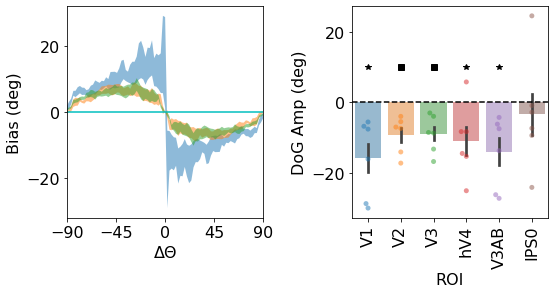

In [14]:
roi_order = ['V1','V2','V3','hV4','V3AB','IPS0']
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
dv=0
roi_view = np.arange(0,6)
p_this=[]
for ri in roi_view:
    cc_this = CC_ALL.cc.values
    these_ind = (CC_ALL.roi==rois[ri])&(CC_ALL.cc>.01)
    p_this.append(scipy.stats.ttest_1samp(CC_ALL[these_ind].DoG_amp,0)[1])
#     plt.plot(bns,np.mean(bias_all[:,cc_this>0,ri,dv],1),linewidth=2)
    if ri<3:
        sem_plot(bns,bias_all[:,:,ri].T,alpha=.5)
# plt.legend(rois[roi_view])
ori_plot(1)
plt.xlabel('$\Delta\\Theta$')
plt.ylabel('Bias (deg)')
# plt.title('Deconvolved Activity')

plt.subplot(1,2,2)

sns.barplot(data=CC_ALL,
            x='roi',y='DoG_amp',ci=68,dodge=.1,alpha=.5,order=roi_order)
sns.swarmplot(data=CC_ALL,
            x='roi',y='DoG_amp',dodge=.1,alpha=.5,order=roi_order)
# sns.swarmplot(data=CC_ALL[(CC_ALL.decoder==['stim','probe','ensamble'][dv])&(np.isin(CC_ALL.roi,rois[roi_view]))&(np.abs(CC_ALL.DoG_amp)<200)&(CC_ALL.cc>0)],x='roi',y='DoG_amp',dodge=.1)
plt.plot([-.5,len(roi_view)-.5],[0,0],'k--')
p01 = (np.array(p_this)<.01)
p05 = (np.array(p_this)<.05)&~p01
plt.plot(np.where(p05)[0],[10]*np.sum(p05),'k*')
plt.plot(np.where(p01)[0],[10]*np.sum(p01),'ks')
plt.tight_layout()
plt.ylabel('DoG Amp (deg)')
plt.xlabel('ROI')

plt.xticks(rotation=90)
# sav_fig('Deconve N-1_clean_DNC')
plt.show()

In [16]:
bias_x_roi = CC_ALL[np.isin(CC_ALL.roi,rois[roi_view])].groupby('roi').DoG_amp.mean().values
this_t= scipy.stats.ttest_1samp(bias_x_roi,0)
print('t(%d)=%.2f, p=%.4f' %(len(bias_x_roi)-1,*this_t))

t(5)=-5.78, p=0.0022


In [17]:
# decode all first, all decoders and stim epochs
DEC_ALL = pd.Series()
CC_DEC = pd.DataFrame()
this_model = DNC()
for si,subj in enumerate(subjs):
    print(subj)
    blocks = block_dat[subj]['block']
    n_trial = len(blocks)
    n_block = n_trial//17
    
    bad_ind = np.isin(blocks,bad_sess)
    blocks = blocks[~bad_ind]
    ori_og = dat[subj]['ori']
    trial = np.concatenate([np.arange(17) for i in range(n_block)])
#     d_ori = np.concatenate(([0]*nb,wrap(ori[:-nb]-ori[nb:])))[~bad_ind]
    
    ori = dat[subj]['ori'][~bad_ind].astype(int) # just remove bad blocks at this stage, bad trials later
    ori_n_1 = np.concatenate(([0],ori[:-1])).astype(int)

    n_trial= len(ori)
    
    block_u=np.unique(blocks)
    n_sess = len(block_u)
    G_task=np.ones(len(blocks))
    for i,gi in enumerate(np.arange(0,n_sess,4)):
        G_task[np.isin(blocks,block_u[gi:gi+4])] = i
        
    dec_subj = pd.Series({'ori':ori,'G':G_task,'trial':trial,'ori_og':ori_og,'bad_ind':bad_ind})
    for ri,roi in enumerate(rois):
        dec_roi = pd.Series()
        roi_dat = dat[subj][roi] # stimW, probeW, selective_voxels (trials x voxels)
        roi_dat.keys()
        
        stimW = roi_dat['stimW'][~bad_ind,:] # note this dat is in order of selective voxels..
        stimW=stimW[:,~np.any(np.isnan(stimW),0)]
#         stimW=stimW[:,-n_voxel_use:]
        
        probeW = roi_dat['probeW'][~bad_ind,:]
        probeW=probeW[:,~np.any(np.isnan(probeW),0)]
#         probeW=probeW[:,-n_voxel_use:]
        
        for ni, theseW in enumerate((stimW,probeW)):
            stim_nam = ('stim','probe')[ni]
            dec_IEM = IEMmodel.fit_CV_IEM(theseW,ori,G_task)
            dec_reg = CR.circ_regr_cval(theseW,ori,G_task)
#             outStim = this_model.fit_CV(theseW,ori,G_task)
#             dec_DNC = outStim['estBNC']
            
            dec_roi[stim_nam] = pd.Series({'decIEM':dec_IEM['estIEM'],'uncIEM':dec_IEM['uncIEM'],
                                  'decReg':dec_reg})#,'dec_BNC':outStim['estBNC'],'est_BNC':outStim['uncBNC']})
            
            cc_IEM= CR.circ_corr_coef(ori,dec_IEM['estIEM']) 
            cc_reg= CR.circ_corr_coef(ori,dec_reg) 
#             cc_BNC= CR.circ_corr_coef(ori,outStim['estBNC']) 
            
            CC_DEC = CC_DEC.append({'subj':subj,'roi':roi,'stim':stim_nam,'dec':'IEM','cc':cc_IEM},ignore_index=1)
            CC_DEC = CC_DEC.append({'subj':subj,'roi':roi,'stim':stim_nam,'dec':'Reg','cc':cc_reg},ignore_index=1)
#             CC_DEC = CC_DEC.append({'subj':subj,'roi':roi,'stim':stim_nam,'dec':'"BNC"','cc':cc_BNC},ignore_index=1)
        dec_subj[roi]=dec_roi
    DEC_ALL[subj]=dec_subj

<ipython-input-17-70b6e38167e6>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  DEC_ALL = pd.Series()
<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


UCSD054
0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 UCSD060
0.0 1.0 2.0 3.0 4.0 5.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


6.0 7.0 8.0 9.0 10.0 11.0 12.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 UCSD061
0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 UCSD062
0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 UCSD063
0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 UCSD064
0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


9.0 10.0 11.0 12.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 

<ipython-input-17-70b6e38167e6>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dec_roi = pd.Series()


0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 

In [19]:
p_bad_all = np.zeros((n_subj,n_roi))
for si,subj in enumerate(subjs):
    for ri,roi in enumerate(rois):
        roi_dat = dat[subj][roi]
        p_bad = np.mean(np.isnan(roi_dat['stimW'][0,:]))
        p_bad_all[si,ri] = p_bad
print('% bad voxels ', np.mean(p_bad_all))

% bad voxels  0.10972234328617975


# Performance of different decoders x ROIs

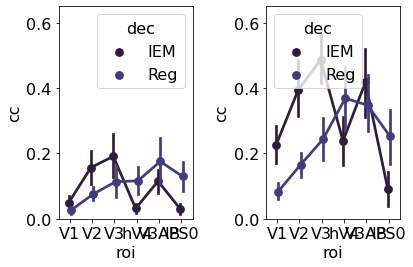

In [20]:
yl = (0,.65)
for i in range(2):
    plt.subplot(1,2,i+1)
    stim_want = ('stim','probe')[i]
    sns.pointplot(x='roi',y='cc',hue='dec',data=CC_DEC[CC_DEC.stim==stim_want],ci=68,dodge=.1)
#     sns.swarmplot(x='roi',y='cc',hue='dec',data=CC_DEC[CC_DEC.stim==stim_want],dodge=.1)
    plt.ylim(yl)
#     sns.swarmplot(x='roi',y='cc',hue='dec',data=CC_DEC[CC_DEC.stim==stim_want],dodge=.1)
plt.tight_layout()
plt.show()

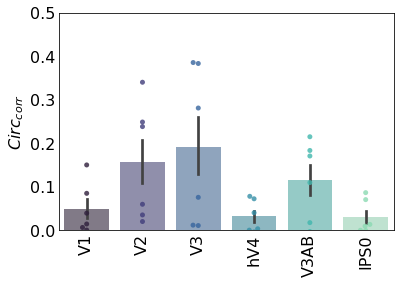

In [21]:
sns.barplot(x='roi',y='cc',data=CC_DEC[(CC_DEC.stim=='stim')&(CC_DEC.dec=='IEM')],ci=68,alpha=.6)
sns.swarmplot(x='roi',y='cc',data=CC_DEC[(CC_DEC.stim=='stim')&(CC_DEC.dec=='IEM')],alpha=.8,edgecolor=None)
plt.ylim(0,0.5)
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('$Circ_{corr}$')
plt.tick_params(axis='both', which='both', length=0)
plt.show()

In [24]:
for ri,roi in enumerate(rois):
    these_val = CC_DEC[(CC_DEC.stim=='stim')&(CC_DEC.dec=='IEM')&(CC_DEC.roi==roi)].cc.values
    this_t = scipy.stats.ttest_1samp(these_val,0)
    this_p = this_t[1]/2
    print('mean:%.2f +/-%.4f \tT:%.2f p=%.3f' %(np.mean(these_val),std_e(these_val),this_t[0],this_p))

mean:0.05 +/-0.0217 	T:2.06 p=0.047
mean:0.16 +/-0.0505 	T:2.84 p=0.018
mean:0.19 +/-0.0669 	T:2.61 p=0.024
mean:0.03 +/-0.0139 	T:2.08 p=0.046
mean:0.12 +/-0.0338 	T:3.11 p=0.013
mean:0.03 +/-0.0143 	T:1.90 p=0.058


In [29]:
df = 0 
overlap=8
roi_show = ['V1','V2','V3','V3AB','hV4','IPS0']
n_backs = [-1,1]
n_n_back = len(n_backs)

bias_all_nb = np.zeros((n_n_back,n_subj,n_roi,n_bns)) # n_back_get
DoG_all_nb = np.zeros((n_n_back,n_subj,n_roi,2))
DoG_nb_df = pd.DataFrame()
stim_use = ['stim','probe'][0]

dec_use = ['decIEM','decReg','dec_BNC'][0]
for si,subj in enumerate(subjs):
    blocks = block_dat[subj]['block']
    bad_ind = np.isin(blocks,bad_sess)
    ori_og = dat[subj]['ori']
    ori = DEC_ALL[subj]['ori']
    trial = DEC_ALL[subj]['trial']
    for ri,roi in enumerate(roi_show):
        dec_stim = DEC_ALL[subj][roi][stim_use][dec_use]
        E = wrap(dec_stim-ori)
        for ni,nb in enumerate(n_backs):
            this_d,bad_d = get_nb(ori_og,nb)
            if nb<0:
                ind_use = (trial<16)
            else:
                ind_use = (trial>=nb)
            these_ind_use = ind_use[~bad_ind]
            d_ori = this_d[ind_use&~bad_ind]
            
            bias_all_nb[ni,si,ri] = do_bining(bns,overlap,d_ori,E[these_ind_use],flip=df,want_var=3)
            vals = (d_ori,E[these_ind_use])
            
            this_fit = scipy.optimize.minimize(min_fun_dog_neural,(0,.025),args = (vals,),bounds=dog_bnds)
            
            DoG_all_nb[ni,si,ri,:] = this_fit.x
            DoG_nb_df=DoG_nb_df.append({'subj':subj,'roi':roi,'DoGAmp':this_fit.x[0],'nb':nb},ignore_index=1)
        

# Bias x ROI, Figure 3B

V1 t=-10.51 p=0.000
V2 t=-11.18 p=0.000
V3 t=-3.56 p=0.008
hV4 t=-3.20 p=0.012
V3AB t=-2.14 p=0.043
IPS0 t=-0.27 p=0.399


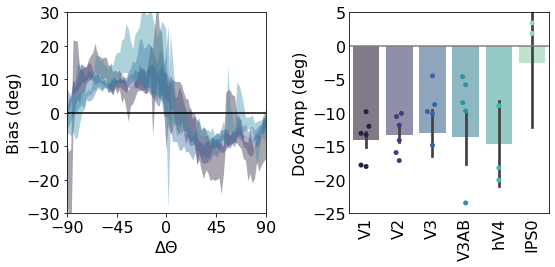

In [30]:
sns.set_palette('mako',6)
roi_show = ['V1','V2','V3','V3AB','hV4','IPS0']
nb=1
this_ind = np.where(np.array(n_backs)==nb)[0][0]
yl = (-30,30)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
for ri in range(4):
    sem_plot(bns,bias_all_nb[this_ind,:,ri],alpha=.4)
d_plot(1)
plt.ylabel('Bias (deg)')
plt.ylim(yl)
plt.xlabel('$\Delta \\Theta$')
plt.subplot(1,2,2)
sns.barplot(x='roi',y='DoGAmp',data=DoG_nb_df[DoG_nb_df.nb==nb],ci=68,alpha=.6,hue_order=roi_show)
sns.swarmplot(x='roi',y='DoGAmp',data=DoG_nb_df[DoG_nb_df.nb==nb],hue_order=roi_show,edgecolor=None)
# plt.xticks(np.arange(6),roi_order,rotation=90)
# plt.plot([-.5,5.5],[0,0],'k--')
# plt.ylabel('DoG Amp (deg)')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('DoG Amp (deg)')
plt.tick_params(axis='both', which='both', length=0)
plt.plot([-.5,5.5],[0,0],color='gray')
plt.ylim(-25,5)
# plt.xticks()
plt.tight_layout()

# plt.show()
# sav_fig('DoubleGammaBias_no_flip_wDots')


for ri,this_roi in enumerate(roi_order):
    these_vals = DoG_all_nb[this_ind,:,ri,0]
    this_t = scipy.stats.ttest_1samp(these_vals,0)
    this_p = this_t[1]/2 # one tailed test
    print('%s t=%.2f p=%.3f' %(this_roi,this_t[0],this_p))